In [1]:
import numpy as np
import time
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import tensorflow as tf
import torchvision
import torch

from sklearn.metrics import accuracy_score

from torch.utils.data import DataLoader
from torch import optim
from torch.autograd import Variable

# Parameters

In [2]:
BATCH_SIZE = 100
EPOCHS = 2
LEARNING_RATE = 0.01
LOSS_FUNCTION = nn.CrossEntropyLoss()

# Importing Data

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(),
)

testing_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [4]:
data_loaders = {
    'train' : DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1),
    'test'  : DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1),
}

# Helper Functions

In [5]:
def displayMNIST(data, index, title="Title", save=False):
    
    plt.imshow(data.data[index], cmap='gray')
    
    if save: plt.savefig(title+".png")
    
    plt.show()

In [6]:
def displayImage(data, index, title="Title", save=False):
    
    data = [item.detach().numpy() for item in data]
    
    plt.imshow(data[index].reshape(28,28), cmap='gray')
    
    if save: plt.savefig(title+".png")
    
    plt.show()

In [7]:
def getLabel(data, index):
    
    return data.targets[index].numpy().item()

In [47]:
def plotAccuracy(accuracy, title="Title", save=False):
    
    plt.plot(range(len(accuracy)), accuracy, '-g', label='Accuracy')
    
    plt.legend(loc='upper left')
    
    if save: plt.savefig(title+"_Accuracy.png")

    plt.show()

In [9]:
def plotLoss(loss, title="Title", save=False):
    
    plt.plot(range(len(loss)), loss, '-r', label='Loss')
    
    plt.legend(loc='upper left')
    
    if save: plt.savefig(title+"_Loss.png")

    plt.show()

# CNN Implementation

In [10]:
class CNN (nn.Module) :
    
    def __init__(self):
        
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.out = nn.Linear(3600, 10)
    
    def forward(self, x):
        
        x = self.layer1(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [11]:
def getLossAccuracy(cnn_model, data_load, dataset, details=False):

    cnn_model.eval()
    
    with torch.no_grad():
        
        correct = 0
        total = 0
        
        for data, label in data_load[dataset]:
            
            output_label, last_layer = cnn_model(data)
            pred_y = torch.max(output_label, 1)[1].data.squeeze()
            
            accuracy = (pred_y == label).sum().item() / float(label.size(0))
            loss = LOSS_FUNCTION(output_label, label).item()
    
    if details: print(dataset+' loss: %.5f' % loss)
    if details: print(dataset+' accuracy: %.5f' % accuracy)
        
    return (loss, accuracy)

In [12]:
def train(cnn_model, data_load, optim):
    
    training_accuracy = []
    training_loss = []
    
    cnn_model.train()
    
    # Initial Training Loss and Accuracy
    (tr_loss, tr_accuracy) = getLossAccuracy(cnn_model, data_load, 'train')            
    training_loss.append(tr_loss)
    training_accuracy.append(tr_accuracy)

    # Train the model
    total_step = len(data_load['train'])

    for epoch in range(EPOCHS):
        for i, (training_data, training_label) in enumerate(data_load['train']):
            
            batch_data = Variable(training_data)
            batch_label = Variable(training_label) 
            output_label, _ = cnn_model(batch_data)               
            
            loss = LOSS_FUNCTION(output_label, batch_label)
  
            optim.zero_grad()           
            loss.backward()             
            optim.step()                

            if (i+1) % 200 == 0:
                print ('Epoch [{}/{}], Progress [{}/{}], Loss: {:.4f}' .format(epoch + 1, EPOCHS, i + 1, total_step, loss.item()))
            
        
        # GET LOSS AND ACCURACY AT EVERY EPOCH
        (tr_loss, tr_accuracy) = getLossAccuracy(cnn_model, data_load, 'train')            
        training_loss.append(tr_loss)
        training_accuracy.append(tr_accuracy)
        #print ('      Training Loss: {:.4f}, Training Accuracy: {:.4f}' .format(tr_loss, tr_accuracy))
            
    return (training_loss, training_accuracy)

### Example

In [13]:
cnn_test = CNN()
optimizer = optim.Adam(cnn_test.parameters(), lr = LEARNING_RATE)  

In [14]:
(train_loss, train_accuracy) = train(cnn_test, data_loaders, optimizer)

Epoch [1/2], Progress [200/600], Loss: 0.0471
Epoch [1/2], Progress [400/600], Loss: 0.0301
Epoch [1/2], Progress [600/600], Loss: 0.0992
Epoch [2/2], Progress [200/600], Loss: 0.0610
Epoch [2/2], Progress [400/600], Loss: 0.0272
Epoch [2/2], Progress [600/600], Loss: 0.1116


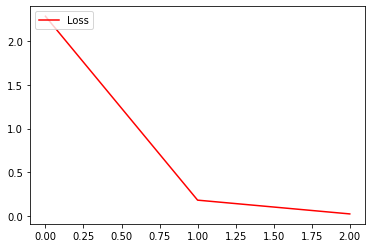

In [15]:
plotLoss(train_loss, "Loss_Train")

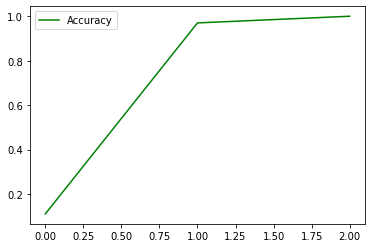

In [16]:
plotAccuracy(train_accuracy, "Accuracy_Train")

In [17]:
(test_loss, test_accuracy) = getLossAccuracy(cnn_test, data_loaders, 'test', details=True)

test loss: 0.16806
test accuracy: 0.96000


# PGD (UNTARGETED)

In [18]:
def getLossAccuracyAdversarial(cnn_model, adversarial_imgs, true_labels, details=False):
    
    true_labels = true_labels.type(torch.int64)
    
    cnn_model.eval()
    
    with torch.no_grad():
        
        correct = 0
        total = 0
        
        output_label, last_layer = cnn_model(adversarial_imgs)
        pred_y = torch.max(output_label, 1)[1].data.squeeze()
        
        #print(pred_y[0:20])
        #print(true_labels[0:20])
        
        accuracy = (pred_y == true_labels).sum().item() / float(true_labels.size(0))
        loss = LOSS_FUNCTION(output_label, true_labels).item()
    
    
    if details: print(dataset+' loss: %.5f' % loss)
    if details: print(dataset+' accuracy: %.5f' % accuracy)
        
    return (loss, accuracy)

In [19]:
def untargeted_pgd_attack(cnn_model, images, true_labels, eps=0.3, alpha=0.001, iterations=1):
    
    original_images = images.data
    
    for j in range(iterations):

        images.requires_grad = True
        (pred_label, _) = cnn_model(images)
        
        loss = LOSS_FUNCTION(pred_label, true_labels)
        loss.backward()

        adv_images = images + alpha * images.grad.sign()
        eta = torch.clamp(adv_images - original_images, min=-eps, max=eps)
        images = torch.clamp(original_images + eta, min=0, max=1).detach_()
            
    return (loss, images, true_labels)

In [23]:
def pgd_train(cnn_model, data_load, optim, pgd_function, eps=0.3, alpha=0.01, iterations=1):
    
    training_accuracy = []
    training_loss = []
    adv_training_loss = []
    adv_training_accuracy = []
    
    cnn_model.train()
    
    # Initial Training Loss and Accuracy
    (tr_loss, tr_accuracy) = getLossAccuracy(cnn_model, data_load, 'train')
    training_loss.append(tr_loss)
    adv_training_loss.append(tr_loss)
    training_accuracy.append(tr_accuracy)
    adv_training_accuracy.append(tr_accuracy)

    # Train the model
    total_step = len(data_load['train'])

    for epoch in range(EPOCHS):
        
        original_images = torch.empty(0,)
        adversarial_images = torch.empty(0,)
        adversarial_labels = torch.empty(0,)
        
        for i, (training_data, training_label) in enumerate(data_load['train']):            
            
            # PGD ATTACK TO PRODUCE ADVERSARIAL EXAMPLES ON THIS BATCH
            (pgd_loss, perturbed_imgs, pgd_label) = pgd_function(cnn_model, training_data, training_label, eps, alpha, iterations)
            
            # COLLECT ALL ADVERSARIAL EXAMPLES
            original_images = torch.cat((original_images, training_data),0)
            adversarial_images = torch.cat((adversarial_images, perturbed_imgs),0)
            adversarial_labels = torch.cat((adversarial_labels, pgd_label),0)
            
            # TRAIN MODEL BASED ON PERTURBED DATA AND UNTARGETTED LABEL
            batch_data = Variable(perturbed_imgs)
            batch_label = Variable(pgd_label)
            
            # PERFORM THE PREDICTION ON CURRENT DATA
            output_label, _ = cnn_model(batch_data)             
            
            # LOSS FUNCTION
            batch_training_loss = LOSS_FUNCTION(output_label, batch_label)
  
            # CLEAR GRADIENTS
            optim.zero_grad() 
        
            # CALCULATE GRADIENTS
            batch_training_loss.backward()   
            
            # UPDATE MODEL PARAMS
            optim.step()                

            if (i+1) % 200 == 0:
                print ('Epoch [{}/{}], Progress [{}/{}], Loss: {:.4f}' .format(epoch + 1, EPOCHS, i + 1, total_step, batch_training_loss))
        
        # GET LOSS AND ACCURACY AT EVERY EPOCH (ON PERTURBED DATA)            
        (tr_loss, tr_accuracy) = getLossAccuracyAdversarial(cnn_pgd, perturbed_imgs, pgd_label)
        adv_training_loss.append(tr_loss)
        adv_training_accuracy.append(tr_accuracy)
        #print ('      Adversarial Loss: {:.4f}, Adversarial Accuracy: {:.4f}' .format(tr_loss, tr_accuracy))
        
        # GET LOSS AND ACCURACY AT EVERY EPOCH (ON ORIGINAL TRAINING DATA)
        (tr_loss, tr_accuracy) = getLossAccuracy(cnn_model, data_load, 'train')            
        training_loss.append(tr_loss)
        training_accuracy.append(tr_accuracy)
        #print ('      Training Loss: {:.4f}, Training Accuracy: {:.4f}' .format(tr_loss, tr_accuracy))
            
    return (original_images, adversarial_images, adversarial_labels, 
            training_loss, training_accuracy, adv_training_loss, adv_training_accuracy)

### Example

In [102]:
cnn_unpgd = CNN()
optimizer_unpgd = optim.Adam(cnn_unpgd.parameters(), lr = LEARNING_RATE)

In [103]:
(original_images, avd_img, avd_lab, 
 train_loss, train_acc, adv_loss, adv_acc) = pgd_train(cnn_unpgd, data_loaders, optimizer_pgd, untargeted_pgd_attack)

Epoch [1/2], Progress [200/600], Loss: 2.3456
Epoch [1/2], Progress [400/600], Loss: 2.3386
Epoch [1/2], Progress [600/600], Loss: 2.3214
Epoch [2/2], Progress [200/600], Loss: 2.3405
Epoch [2/2], Progress [400/600], Loss: 2.3274
Epoch [2/2], Progress [600/600], Loss: 2.3198


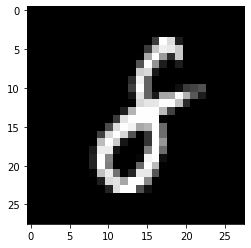

In [26]:
displayImage(original_images, 0)

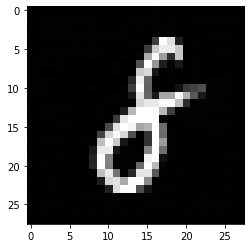

In [27]:
displayImage(avd_img, 0) #IMPERSEPTIBLE ADVERSARIAL EXAMPLE

In [28]:
torch.eq(original_images[0], avd_img[0]) #ALTHOUGH IMPERSEPTIBLE TO HUMAN EYE, STILL HAS A LOT OF DIFFERENCES IN VALUES

tensor([[[False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True, False,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True],
         [ True, False, False, False, False, False, False, False, False,  True,
           True,  True,  True, False, False, False, False,  True, False,  True,
           True, False, False, False, False, False, False,  True],
         [False,  True, False,  True, False,  True,  True,  True, False,  True,
           True,  True, False,  True, False,  True, False, False, False,  True,
           True, False,  True,  True,  True,  True,  True,  True],
         [ True, False, False, False, False, False, False, False, False, False,
          False, False, False,  True,  True,  True,  True,  True, False,  True,
           True,  True,  True, False, False, False, False,  True],
         [False,  True,  True,  True,  True,  True, False,  True, False,  True,
          Fa

In [29]:
avd_lab[0].item()

8.0

In [30]:
print("Accuracy on Adversarial Examples: "+str(adv_acc))
print("Accuracy on Original Training data: "+str(train_acc))

Accuracy on Adversarial Examples: [0.11, 0.96, 0.98]
Accuracy on Original Training data: [0.11, 0.97, 0.99]


In [31]:
print("Loss on Adversarial Examples: "+str(adv_loss))
print("Loss on Original Training data: "+str(train_loss))

Loss on Adversarial Examples: [2.2878258228302, 0.10497304052114487, 0.07250978797674179]
Loss on Original Training data: [2.2878258228302, 0.0938786044716835, 0.019617781043052673]


### Example of Images Produced by NonTrageted PGD

In [33]:
for i, (training_data, training_label) in enumerate(data_loaders['train']):  
    if i==0:
        ex_train_img = training_data
        ex_train_lab = training_label

(_, adv_image_1, adv_label_1) = untargeted_pgd_attack(cnn_pgd, ex_train_img, ex_train_lab, eps=0.3, alpha=0.01, iterations=1)
(_, adv_image_40, adv_label_40) = untargeted_pgd_attack(cnn_pgd, ex_train_img, ex_train_lab, eps=0.3, alpha=0.01, iterations=40)

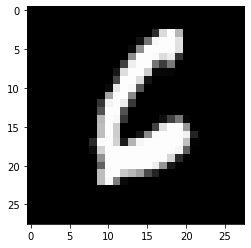

tensor(6)


In [34]:
displayImage(ex_train_img, 0)

print(ex_train_lab[0])

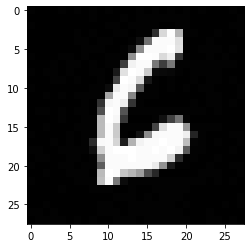

tensor(6)


In [35]:
displayImage(adv_image_1, 0)

print(adv_label_1[0])

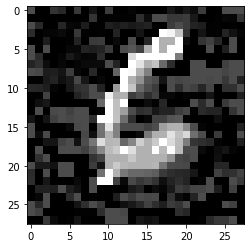

tensor(6)


In [36]:
displayImage(adv_image_40, 0)

print(adv_label_40[0])

In [ ]:
(test_acc, adv_test_acc) = pgd_test(cnn_pgd, data_loaders, untargeted_pgd_attack, details=True)

# PGD (TARGETED)

In [65]:
def targeted_pgd_attack(cnn_model, images, true_labels, eps=0.3, alpha=0.001, iterations=1):
    
    original_images = images.data
    
    for j in range(iterations):

        images.requires_grad = True
        (pred_label, _) = cnn_model(images)
        
        loss = LOSS_FUNCTION(pred_label, true_labels)
        loss.backward()

        adv_images = images + alpha * images.grad.sign()
        eta = torch.clamp(adv_images - original_images, min=-eps, max=eps)
        images = torch.clamp(original_images + eta, min=0, max=1).detach_()
        
    targeted_label, _ = cnn_model(images)
    targeted_label = torch.max(targeted_label, 1)[1].data.squeeze()
            
    return (loss, images, targeted_label)

### Example

In [66]:
cnn_pgd = CNN()
optimizer_pgd = optim.Adam(cnn_pgd.parameters(), lr = LEARNING_RATE)

In [67]:
(original_images, avd_img, avd_lab, 
 train_loss, train_acc, adv_loss, adv_acc) = pgd_train(cnn_pgd, data_loaders, optimizer_pgd, targeted_pgd_attack)

Epoch [1/2], Progress [200/600], Loss: 0.0000
Epoch [1/2], Progress [400/600], Loss: 0.0000
Epoch [1/2], Progress [600/600], Loss: 0.0000
Epoch [2/2], Progress [200/600], Loss: 0.0000
Epoch [2/2], Progress [400/600], Loss: 0.0000
Epoch [2/2], Progress [600/600], Loss: 0.0000


In [68]:
for i, (training_data, training_label) in enumerate(data_loaders['train']):  
    if i in [0]:
        ex_train_img = training_data
        ex_train_lab = training_label

(_, adv_image_1, adv_label_1) = targeted_pgd_attack(cnn_pgd, ex_train_img, ex_train_lab, eps=0.3, alpha=0.01, iterations=1)
(_, adv_image_40, adv_label_40) = targeted_pgd_attack(cnn_pgd, ex_train_img, ex_train_lab, eps=0.3, alpha=0.01, iterations=40)

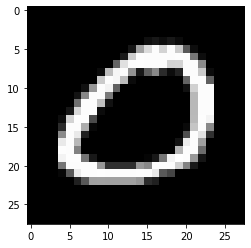

tensor(0)


In [69]:
displayImage(ex_train_img, 0)

print(ex_train_lab[0])

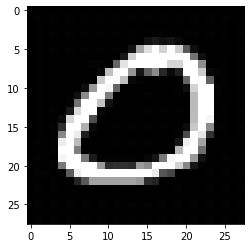

tensor(6)


In [70]:
displayImage(adv_image_1, 0)

print(adv_label_1[0])

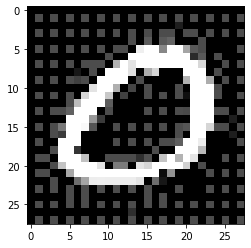

tensor(6)


In [71]:
displayImage(adv_image_40, 0)

print(adv_label_40[0])

In [72]:
torch.eq(ex_train_img[0], adv_image_40[0]) #ALTHOUGH IMPERSEPTIBLE TO HUMAN EYE, STILL HAS A LOT OF DIFFERENCES IN VALUES

tensor([[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True],
         [ True, False,  True, False,  True, False,  True, False,  True, False,
           True, False,  True, False,  True, False,  True, False,  True, False,
           True, False,  True, False,  True, False,  True, False],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True, False,
           True,  True,  True,  True,  True,  True,  True,  True],
         [ True, False,  True, False,  True, False,  True, False,  True, False,
           True, False,  True, False,  True, False,  True, False, False,  True,
          False, False,  True, False,  True, False,  True, False],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           T

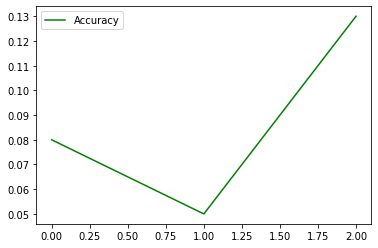

In [73]:
plotAccuracy(train_acc)

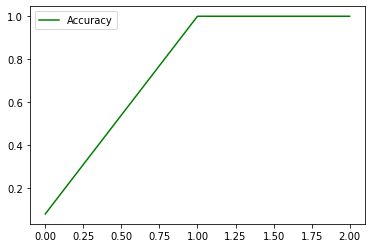

In [74]:
plotAccuracy(adv_acc)

## Evaluating on Test Data

In [105]:
def pgd_test(cnn_model, data_load, pgd_function, eps=0.3, alpha=0.01, iterations=1, details=False):
    
    pgd_accuracy = 0
    
    (_, test_accuracy) = getLossAccuracy(cnn_model, data_load, 'test', details=False)
    
    total_step = len(data_load['train'])
    
    for i, (testing_data, testing_label) in enumerate(data_load['test']): 
    
        (_, adv_image, adv_label) = pgd_function(cnn_model, testing_data, testing_label, eps, alpha, iterations)
        (_, temp) = getLossAccuracyAdversarial(cnn_model, adv_image, testing_label, details=False)
        pgd_accuracy += temp
        
    pgd_accuracy = pgd_accuracy/100
    
    if details: print('Accuracy on original Test Set: %.5f' % test_accuracy)
    if details: print('Accuracy of Perturbed Test Set: %.5f' % pgd_accuracy)
        
    return (test_accuracy, pgd_accuracy)

### Example

In [106]:
(test_acc, adv_test_acc) = pgd_test(cnn_unpgd, data_loaders, untargeted_pgd_attack, details=True) #UNTARGETED

Accuracy on original Test Set: 0.07000
Accuracy of Perturbed Test Set: 0.81400


In [101]:
(test_acc, adv_test_acc) = pgd_test(cnn_pgd, data_loaders, targeted_pgd_attack, details=True) #TARGETED

Accuracy on original Test Set: 0.05000
Accuracy of Perturbed Test Set: 0.95800
